# Introducción

Los algoritmos genéticos funcionan iterando sobre generaciones de poblaciones y evaluando qué tan bien estas poblaciones resuelven un problema. Al final de la generación, se seleccionan las mejores personas para producir la próxima generación.

## Problema

El problema del vendedor viajero, problema del vendedor ambulante, problema del agente viajero o problema del viajante (TSP por sus siglas en inglés (Travelling Salesman Problem)), responde a la siguiente pregunta: dada una lista de ciudades y las distancias entre cada par de ellas, ¿cuál es la ruta más corta posible que visita cada ciudad exactamente una vez y al finalizar regresa a la ciudad origen?

# Importaciones

In [14]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

# Representaciones de datos

Debido a que vamos a trabajar con la forma más simple del TSP, necesitamos una forma de representar los datos:

In [15]:
class City:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) * (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.name) + ")"

# ¿Cómo funciona el algoritmo?

## El concepto de individuo

Un individuo puede verse como una sola instancia del problema, en este caso es fácil ver que el individuo es la secuencia de "ciudades" y el orden en que son visitadas.

## Aptitud
Los algoritmos genéticos imitan las estructuras naturales utilizando la idea de "supervivencia del más apto", por lo que es importante definir una función de aptitud común para todos los individuos. Para este caso, la aptitud de un individuo es la suma de la distancia para cada par de ciudades consecutivas, incluida la suma de la última ciudad de la secuencia y la primera (porque TSP forma un bucle).
>$Fitness=[\sum_{i=1}^{N-1} Distance(City_{i},City_{i+1})]+Distance(City_{N},City_{1})$

Esta función de "Distance" es solo la distancia euclidiana entre cada ciudad.

In [16]:
#Create a fitness function

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Mutación y reproducción
El algoritmo crea las próximas generaciones utilizando dos métodos, ya sea mutando individuos individuales según una probabilidad, o "apareando" dos individuos para crear uno nuevo. Aquí definimos todas las funciones necesarias para realizar el algoritmo.

In [17]:
#Create our initial population
#Route generator
#This method randomizes the order of the cities, this mean that this method creates a random individual.
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route


#Create first "population" (list of routes)
#This method created a random population of the specified size.

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


#Create the genetic algorithm
#Rank individuals
#This function takes a population and orders it in descending order using the fitness of each individual
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    sorted_results=sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)
    return sorted_results



#Create a selection function that will be used to make the list of parent routes

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults



#Create mating pool

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool




#Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        

    childP2 = [item for item in parent2 if item not in childP1]
    print(startGene, endGene)

    print(parent1)
    print(parent2)

    print(childP1)
    print(childP2)
    child = childP1 + childP2

    print(child)
    return child

#Create function to run crossover over full mating pool

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children




#Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual



#Create function to run mutation over entire population

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop



#Put all steps together to create the next generation

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

## El algoritmo genético
Con todas estas funciones definidas, solo queda escribir la definición del algoritmo genético.

In [18]:
#Final step: create the genetic algorithm

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = [1 / rankRoutes(pop)[0][1]]
    print("Initial distance: " + str(progress[0]))
    
    for i in range(1, generations+1):
        
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if i%50==0:
          print('Generation '+str(i),"Distance: ",progress[i])
        
        
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best Fitness vs Generation')
    plt.tight_layout()
    plt.show()

    
    
    return bestRoute

## Pruebas
Hemos creado una lista de ciudades y ejecutamos el algoritmo, esto debería devolver la mejor ruta encontrada en la última generación.

Initial distance: 23174.0
0 1
[(2), (0), (3), (4), (1)]
[(2), (0), (4), (1), (3)]
[(2)]
[(0), (4), (1), (3)]
[(2), (0), (4), (1), (3)]
0 4
[(4), (3), (2), (0), (1)]
[(2), (3), (4), (1), (0)]
[(4), (3), (2), (0)]
[(1)]
[(4), (3), (2), (0), (1)]
0 3
[(3), (0), (2), (1), (4)]
[(3), (4), (1), (0), (2)]
[(3), (0), (2)]
[(4), (1)]
[(3), (0), (2), (4), (1)]
2 3
[(0), (3), (4), (1), (2)]
[(3), (4), (0), (2), (1)]
[(4)]
[(3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
0 1
[(4), (3), (2), (0), (1)]
[(1), (0), (2), (3), (4)]
[(4)]
[(1), (0), (2), (3)]
[(4), (1), (0), (2), (3)]
0 2
[(2), (3), (1), (4), (0)]
[(3), (4), (2), (0), (1)]
[(2), (3)]
[(4), (0), (1)]
[(2), (3), (4), (0), (1)]
0 3
[(4), (0), (2), (1), (3)]
[(4), (1), (0), (3), (2)]
[(4), (0), (2)]
[(1), (3)]
[(4), (0), (2), (1), (3)]
1 2
[(3), (0), (4), (2), (1)]
[(2), (1), (4), (0), (3)]
[(0)]
[(2), (1), (4), (3)]
[(0), (2), (1), (4), (3)]
0 0
[(3), (0), (1), (2), (4)]
[(3), (1), (4), (2), (0)]
[]
[(3), (1), (4), (2), (0)]
[(3), (1), (4), (

[(2)]
[(3), (0), (4), (1)]
[(2), (3), (0), (4), (1)]
1 4
[(4), (1), (2), (0), (3)]
[(1), (4), (3), (2), (0)]
[(1), (2), (0)]
[(4), (3)]
[(1), (2), (0), (4), (3)]
0 1
[(0), (3), (4), (1), (2)]
[(3), (4), (1), (2), (0)]
[(0)]
[(3), (4), (1), (2)]
[(0), (3), (4), (1), (2)]
1 1
[(3), (4), (1), (2), (0)]
[(0), (2), (1), (4), (3)]
[]
[(0), (2), (1), (4), (3)]
[(0), (2), (1), (4), (3)]
0 4
[(0), (1), (3), (4), (2)]
[(3), (4), (0), (2), (1)]
[(0), (1), (3), (4)]
[(2)]
[(0), (1), (3), (4), (2)]
1 4
[(4), (3), (0), (2), (1)]
[(0), (2), (1), (4), (3)]
[(3), (0), (2)]
[(1), (4)]
[(3), (0), (2), (1), (4)]
2 4
[(3), (0), (1), (4), (2)]
[(0), (3), (4), (1), (2)]
[(1), (4)]
[(0), (3), (2)]
[(1), (4), (0), (3), (2)]
2 4
[(0), (3), (4), (1), (2)]
[(0), (2), (1), (4), (3)]
[(4), (1)]
[(0), (2), (3)]
[(4), (1), (0), (2), (3)]
2 4
[(1), (4), (3), (0), (2)]
[(3), (0), (1), (4), (2)]
[(3), (0)]
[(1), (4), (2)]
[(3), (0), (1), (4), (2)]
1 3
[(3), (4), (1), (2), (0)]
[(1), (2), (0), (3), (4)]
[(4), (1)]
[(2), 

[]
[(0), (3), (4), (1), (2)]
[(0), (3), (4), (1), (2)]
1 2
[(2), (3), (1), (4), (0)]
[(0), (3), (4), (1), (2)]
[(3)]
[(0), (4), (1), (2)]
[(3), (0), (4), (1), (2)]
0 0
[(4), (2), (0), (3), (1)]
[(4), (3), (0), (1), (2)]
[]
[(4), (3), (0), (1), (2)]
[(4), (3), (0), (1), (2)]
3 3
[(1), (0), (2), (3), (4)]
[(2), (1), (4), (3), (0)]
[]
[(2), (1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
1 4
[(1), (4), (2), (3), (0)]
[(0), (2), (1), (4), (3)]
[(4), (2), (3)]
[(0), (1)]
[(4), (2), (3), (0), (1)]
3 4
[(2), (1), (3), (0), (4)]
[(4), (2), (0), (3), (1)]
[(0)]
[(4), (2), (3), (1)]
[(0), (4), (2), (3), (1)]
0 4
[(2), (0), (3), (4), (1)]
[(2), (1), (3), (0), (4)]
[(2), (0), (3), (4)]
[(1)]
[(2), (0), (3), (4), (1)]
1 4
[(1), (2), (0), (3), (4)]
[(1), (4), (2), (0), (3)]
[(2), (0), (3)]
[(1), (4)]
[(2), (0), (3), (1), (4)]
0 3
[(1), (0), (2), (3), (4)]
[(0), (2), (1), (4), (3)]
[(1), (0), (2)]
[(4), (3)]
[(1), (0), (2), (4), (3)]
0 2
[(1), (0), (2), (3), (4)]
[(2), (0), (3), (4), (1)]
[(1), (0)]
[(

1 2
[(4), (3), (0), (2), (1)]
[(3), (1), (4), (2), (0)]
[(3)]
[(1), (4), (2), (0)]
[(3), (1), (4), (2), (0)]
1 4
[(3), (4), (1), (2), (0)]
[(4), (3), (2), (0), (1)]
[(4), (1), (2)]
[(3), (0)]
[(4), (1), (2), (3), (0)]
0 2
[(0), (3), (4), (1), (2)]
[(2), (0), (3), (4), (1)]
[(0), (3)]
[(2), (4), (1)]
[(0), (3), (2), (4), (1)]
2 4
[(2), (0), (3), (4), (1)]
[(3), (0), (4), (1), (2)]
[(3), (4)]
[(0), (1), (2)]
[(3), (4), (0), (1), (2)]
1 3
[(4), (0), (3), (1), (2)]
[(3), (4), (1), (2), (0)]
[(0), (3)]
[(4), (1), (2)]
[(0), (3), (4), (1), (2)]
0 2
[(4), (3), (0), (2), (1)]
[(2), (0), (3), (4), (1)]
[(4), (3)]
[(2), (0), (1)]
[(4), (3), (2), (0), (1)]
1 4
[(1), (4), (3), (0), (2)]
[(3), (0), (2), (1), (4)]
[(4), (3), (0)]
[(2), (1)]
[(4), (3), (0), (2), (1)]
0 3
[(4), (3), (2), (0), (1)]
[(2), (1), (4), (3), (0)]
[(4), (3), (2)]
[(1), (0)]
[(4), (3), (2), (1), (0)]
1 2
[(3), (4), (1), (2), (0)]
[(1), (2), (0), (3), (4)]
[(4)]
[(1), (2), (0), (3)]
[(4), (1), (2), (0), (3)]
2 4
[(4), (3), (0),

1 3
[(0), (3), (4), (1), (2)]
[(4), (3), (0), (2), (1)]
[(3), (4)]
[(0), (2), (1)]
[(3), (4), (0), (2), (1)]
0 4
[(4), (2), (0), (3), (1)]
[(0), (3), (2), (4), (1)]
[(4), (2), (0), (3)]
[(1)]
[(4), (2), (0), (3), (1)]
2 4
[(0), (3), (2), (4), (1)]
[(4), (2), (0), (3), (1)]
[(2), (4)]
[(0), (3), (1)]
[(2), (4), (0), (3), (1)]
0 1
[(4), (3), (0), (2), (1)]
[(0), (3), (4), (1), (2)]
[(4)]
[(0), (3), (1), (2)]
[(4), (0), (3), (1), (2)]
1 3
[(1), (2), (0), (3), (4)]
[(1), (2), (3), (4), (0)]
[(2), (0)]
[(1), (3), (4)]
[(2), (0), (1), (3), (4)]
2 4
[(4), (3), (0), (2), (1)]
[(4), (2), (0), (3), (1)]
[(0), (2)]
[(4), (3), (1)]
[(0), (2), (4), (3), (1)]
0 1
[(4), (3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
[(4)]
[(3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
0 0
[(1), (2), (0), (3), (4)]
[(4), (3), (0), (2), (1)]
[]
[(4), (3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
2 4
[(1), (2), (0), (3), (4)]
[(4), (0), (3), (1), (2)]
[(0), (3)]
[(4), (1), (2)]
[(0), (3), (4), (1), (2)]
2 3
[(4), (2), (0

4 4
[(0), (1), (4), (3), (2)]
[(1), (2), (0), (3), (4)]
[]
[(1), (2), (0), (3), (4)]
[(1), (2), (0), (3), (4)]
0 2
[(0), (2), (1), (4), (3)]
[(4), (3), (0), (2), (1)]
[(0), (2)]
[(4), (3), (1)]
[(0), (2), (4), (3), (1)]
1 4
[(1), (4), (3), (0), (2)]
[(1), (4), (3), (0), (2)]
[(4), (3), (0)]
[(1), (2)]
[(4), (3), (0), (1), (2)]
2 2
[(3), (0), (2), (1), (4)]
[(1), (4), (3), (0), (2)]
[]
[(1), (4), (3), (0), (2)]
[(1), (4), (3), (0), (2)]
0 2
[(3), (1), (2), (0), (4)]
[(4), (3), (0), (2), (1)]
[(3), (1)]
[(4), (0), (2)]
[(3), (1), (4), (0), (2)]
0 2
[(3), (0), (2), (1), (4)]
[(3), (0), (2), (1), (4)]
[(3), (0)]
[(2), (1), (4)]
[(3), (0), (2), (1), (4)]
1 2
[(1), (4), (3), (0), (2)]
[(0), (4), (2), (3), (1)]
[(4)]
[(0), (2), (3), (1)]
[(4), (0), (2), (3), (1)]
4 4
[(4), (3), (0), (2), (1)]
[(0), (2), (1), (4), (3)]
[]
[(0), (2), (1), (4), (3)]
[(0), (2), (1), (4), (3)]
1 1
[(1), (0), (4), (3), (2)]
[(3), (0), (2), (1), (4)]
[]
[(3), (0), (2), (1), (4)]
[(3), (0), (2), (1), (4)]
2 3
[(1), (

0 2
[(3), (1), (0), (2), (4)]
[(4), (3), (0), (2), (1)]
[(3), (1)]
[(4), (0), (2)]
[(3), (1), (4), (0), (2)]
0 4
[(4), (3), (0), (2), (1)]
[(0), (3), (4), (1), (2)]
[(4), (3), (0), (2)]
[(1)]
[(4), (3), (0), (2), (1)]
1 4
[(2), (1), (4), (3), (0)]
[(1), (2), (4), (0), (3)]
[(1), (4), (3)]
[(2), (0)]
[(1), (4), (3), (2), (0)]
2 3
[(2), (0), (3), (4), (1)]
[(0), (4), (3), (1), (2)]
[(3)]
[(0), (4), (1), (2)]
[(3), (0), (4), (1), (2)]
2 4
[(2), (0), (3), (4), (1)]
[(3), (0), (4), (1), (2)]
[(3), (4)]
[(0), (1), (2)]
[(3), (4), (0), (1), (2)]
0 4
[(4), (3), (0), (1), (2)]
[(3), (0), (2), (1), (4)]
[(4), (3), (0), (1)]
[(2)]
[(4), (3), (0), (1), (2)]
1 1
[(0), (3), (4), (1), (2)]
[(0), (2), (1), (4), (3)]
[]
[(0), (2), (1), (4), (3)]
[(0), (2), (1), (4), (3)]
2 3
[(2), (0), (3), (4), (1)]
[(3), (0), (2), (1), (4)]
[(3)]
[(0), (2), (1), (4)]
[(3), (0), (2), (1), (4)]
2 2
[(4), (1), (0), (2), (3)]
[(4), (3), (0), (2), (1)]
[]
[(4), (3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
1 4
[(3), (4), 

0 1
[(0), (3), (4), (1), (2)]
[(1), (2), (0), (3), (4)]
[(0)]
[(1), (2), (3), (4)]
[(0), (1), (2), (3), (4)]
1 4
[(1), (2), (0), (3), (4)]
[(3), (0), (1), (4), (2)]
[(2), (0), (3)]
[(1), (4)]
[(2), (0), (3), (1), (4)]
0 1
[(0), (2), (3), (4), (1)]
[(4), (3), (0), (2), (1)]
[(0)]
[(4), (3), (2), (1)]
[(0), (4), (3), (2), (1)]
2 3
[(3), (0), (2), (1), (4)]
[(0), (1), (2), (3), (4)]
[(2)]
[(0), (1), (3), (4)]
[(2), (0), (1), (3), (4)]
0 3
[(3), (4), (1), (2), (0)]
[(0), (3), (4), (1), (2)]
[(3), (4), (1)]
[(0), (2)]
[(3), (4), (1), (0), (2)]
1 4
[(2), (0), (3), (4), (1)]
[(0), (2), (1), (4), (3)]
[(0), (3), (4)]
[(2), (1)]
[(0), (3), (4), (2), (1)]
0 3
[(1), (3), (0), (4), (2)]
[(0), (3), (4), (1), (2)]
[(1), (3), (0)]
[(4), (2)]
[(1), (3), (0), (4), (2)]
1 1
[(0), (3), (4), (1), (2)]
[(0), (2), (1), (3), (4)]
[]
[(0), (2), (1), (3), (4)]
[(0), (2), (1), (3), (4)]
2 4
[(4), (1), (3), (0), (2)]
[(0), (3), (4), (2), (1)]
[(3), (0)]
[(4), (2), (1)]
[(3), (0), (4), (2), (1)]
0 3
[(1), (4), (3

[(1), (3), (0)]
[(4), (2), (1), (3), (0)]
1 2
[(0), (2), (1), (4), (3)]
[(1), (4), (3), (0), (2)]
[(2)]
[(1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
1 3
[(4), (2), (0), (3), (1)]
[(4), (3), (0), (2), (1)]
[(2), (0)]
[(4), (3), (1)]
[(2), (0), (4), (3), (1)]
1 1
[(1), (3), (4), (2), (0)]
[(1), (3), (2), (4), (0)]
[]
[(1), (3), (2), (4), (0)]
[(1), (3), (2), (4), (0)]
1 2
[(2), (0), (1), (3), (4)]
[(4), (2), (0), (3), (1)]
[(0)]
[(4), (2), (3), (1)]
[(0), (4), (2), (3), (1)]
0 0
[(4), (1), (3), (0), (2)]
[(2), (0), (3), (4), (1)]
[]
[(2), (0), (3), (4), (1)]
[(2), (0), (3), (4), (1)]
4 4
[(3), (0), (4), (2), (1)]
[(4), (3), (0), (2), (1)]
[]
[(4), (3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
3 4
[(3), (0), (2), (1), (4)]
[(1), (4), (3), (0), (2)]
[(1)]
[(4), (3), (0), (2)]
[(1), (4), (3), (0), (2)]
1 3
[(3), (4), (1), (2), (0)]
[(2), (0), (3), (4), (1)]
[(4), (1)]
[(2), (0), (3)]
[(4), (1), (2), (0), (3)]
0 0
[(1), (3), (4), (2), (0)]
[(1), (4), (3), (0), (2)]
[]
[(1), (4), (3), (0), 

[(3), (0)]
[(2), (4), (1)]
[(3), (0), (2), (4), (1)]
2 2
[(0), (3), (4), (1), (2)]
[(1), (3), (0), (2), (4)]
[]
[(1), (3), (0), (2), (4)]
[(1), (3), (0), (2), (4)]
1 2
[(1), (2), (4), (3), (0)]
[(1), (4), (3), (0), (2)]
[(2)]
[(1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
0 1
[(2), (0), (3), (4), (1)]
[(1), (4), (3), (0), (2)]
[(2)]
[(1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
0 4
[(3), (4), (1), (2), (0)]
[(4), (3), (0), (2), (1)]
[(3), (4), (1), (2)]
[(0)]
[(3), (4), (1), (2), (0)]
0 2
[(4), (3), (0), (2), (1)]
[(3), (1), (4), (0), (2)]
[(4), (3)]
[(1), (0), (2)]
[(4), (3), (1), (0), (2)]
1 4
[(3), (4), (1), (2), (0)]
[(0), (2), (1), (4), (3)]
[(4), (1), (2)]
[(0), (3)]
[(4), (1), (2), (0), (3)]
1 1
[(0), (3), (4), (1), (2)]
[(4), (3), (0), (2), (1)]
[]
[(4), (3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
4 4
[(0), (3), (4), (2), (1)]
[(1), (4), (3), (0), (2)]
[]
[(1), (4), (3), (0), (2)]
[(1), (4), (3), (0), (2)]
0 1
[(1), (4), (3), (0), (2)]
[(1), (4), (3), (0), (2)]
[(1)]
[(4), (

[(1), (0), (3), (4), (2)]
[(2), (1), (4), (3), (0)]
[(0), (3), (4)]
[(2), (1)]
[(0), (3), (4), (2), (1)]
1 3
[(1), (4), (3), (0), (2)]
[(2), (0), (3), (4), (1)]
[(4), (3)]
[(2), (0), (1)]
[(4), (3), (2), (0), (1)]
2 4
[(1), (4), (3), (0), (2)]
[(1), (2), (0), (3), (4)]
[(3), (0)]
[(1), (2), (4)]
[(3), (0), (1), (2), (4)]
2 2
[(4), (3), (0), (2), (1)]
[(2), (0), (3), (4), (1)]
[]
[(2), (0), (3), (4), (1)]
[(2), (0), (3), (4), (1)]
1 2
[(0), (2), (3), (4), (1)]
[(0), (3), (4), (1), (2)]
[(2)]
[(0), (3), (4), (1)]
[(2), (0), (3), (4), (1)]
2 4
[(0), (3), (4), (1), (2)]
[(1), (0), (3), (4), (2)]
[(4), (1)]
[(0), (3), (2)]
[(4), (1), (0), (3), (2)]
2 2
[(2), (4), (3), (0), (1)]
[(1), (4), (3), (0), (2)]
[]
[(1), (4), (3), (0), (2)]
[(1), (4), (3), (0), (2)]
0 3
[(4), (3), (0), (2), (1)]
[(1), (2), (0), (3), (4)]
[(4), (3), (0)]
[(1), (2)]
[(4), (3), (0), (1), (2)]
0 3
[(2), (4), (0), (3), (1)]
[(3), (0), (2), (1), (4)]
[(2), (4), (0)]
[(3), (1)]
[(2), (4), (0), (3), (1)]
2 3
[(1), (0), (3),

[(1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
0 4
[(0), (3), (4), (1), (2)]
[(2), (0), (3), (4), (1)]
[(0), (3), (4), (1)]
[(2)]
[(0), (3), (4), (1), (2)]
1 1
[(1), (4), (3), (0), (2)]
[(0), (2), (1), (4), (3)]
[]
[(0), (2), (1), (4), (3)]
[(0), (2), (1), (4), (3)]
2 4
[(1), (0), (3), (4), (2)]
[(4), (1), (3), (0), (2)]
[(3), (4)]
[(1), (0), (2)]
[(3), (4), (1), (0), (2)]
2 4
[(1), (3), (4), (0), (2)]
[(0), (3), (4), (2), (1)]
[(4), (0)]
[(3), (2), (1)]
[(4), (0), (3), (2), (1)]
0 3
[(2), (0), (1), (4), (3)]
[(3), (0), (2), (1), (4)]
[(2), (0), (1)]
[(3), (4)]
[(2), (0), (1), (3), (4)]
1 4
[(1), (0), (3), (4), (2)]
[(2), (4), (1), (3), (0)]
[(0), (3), (4)]
[(2), (1)]
[(0), (3), (4), (2), (1)]
0 2
[(2), (1), (4), (3), (0)]
[(0), (3), (4), (1), (2)]
[(2), (1)]
[(0), (3), (4)]
[(2), (1), (0), (3), (4)]
2 3
[(1), (2), (0), (3), (4)]
[(0), (2), (3), (4), (1)]
[(0)]
[(2), (3), (4), (1)]
[(0), (2), (3), (4), (1)]
1 2
[(0), (3), (4), (1), (2)]
[(2), (0), (3), (4), (1)]
[(3)]
[(2), (0), (4), (

0 2
[(4), (0), (3), (2), (1)]
[(2), (0), (3), (4), (1)]
[(4), (0)]
[(2), (3), (1)]
[(4), (0), (2), (3), (1)]
1 3
[(0), (3), (4), (1), (2)]
[(4), (2), (0), (3), (1)]
[(3), (4)]
[(2), (0), (1)]
[(3), (4), (2), (0), (1)]
2 2
[(1), (4), (3), (0), (2)]
[(0), (3), (4), (2), (1)]
[]
[(0), (3), (4), (2), (1)]
[(0), (3), (4), (2), (1)]
3 4
[(1), (2), (4), (3), (0)]
[(3), (2), (1), (4), (0)]
[(3)]
[(2), (1), (4), (0)]
[(3), (2), (1), (4), (0)]
0 2
[(1), (2), (0), (3), (4)]
[(3), (0), (2), (1), (4)]
[(1), (2)]
[(3), (0), (4)]
[(1), (2), (3), (0), (4)]
2 4
[(3), (0), (2), (1), (4)]
[(1), (2), (0), (3), (4)]
[(2), (1)]
[(0), (3), (4)]
[(2), (1), (0), (3), (4)]
1 2
[(3), (2), (1), (4), (0)]
[(1), (2), (4), (3), (0)]
[(2)]
[(1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
1 3
[(0), (3), (4), (2), (1)]
[(1), (4), (3), (0), (2)]
[(3), (4)]
[(1), (0), (2)]
[(3), (4), (1), (0), (2)]
0 2
[(4), (2), (0), (3), (1)]
[(0), (3), (4), (1), (2)]
[(4), (2)]
[(0), (3), (1)]
[(4), (2), (0), (3), (1)]
1 2
[(2), (0), (3

[(0), (3), (4), (1), (2)]
[(3)]
[(0), (4), (1), (2)]
[(3), (0), (4), (1), (2)]
0 4
[(1), (4), (0), (3), (2)]
[(1), (4), (3), (0), (2)]
[(1), (4), (0), (3)]
[(2)]
[(1), (4), (0), (3), (2)]
3 4
[(4), (1), (2), (0), (3)]
[(1), (4), (2), (0), (3)]
[(0)]
[(1), (4), (2), (3)]
[(0), (1), (4), (2), (3)]
4 4
[(3), (4), (1), (2), (0)]
[(2), (1), (4), (3), (0)]
[]
[(2), (1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
1 2
[(3), (4), (0), (1), (2)]
[(0), (3), (1), (2), (4)]
[(4)]
[(0), (3), (1), (2)]
[(4), (0), (3), (1), (2)]
0 2
[(3), (0), (2), (1), (4)]
[(2), (1), (0), (3), (4)]
[(3), (0)]
[(2), (1), (4)]
[(3), (0), (2), (1), (4)]
0 2
[(3), (4), (1), (2), (0)]
[(1), (4), (0), (3), (2)]
[(3), (4)]
[(1), (0), (2)]
[(3), (4), (1), (0), (2)]
1 4
[(2), (0), (3), (4), (1)]
[(3), (4), (0), (1), (2)]
[(0), (3), (4)]
[(1), (2)]
[(0), (3), (4), (1), (2)]
0 1
[(4), (3), (0), (2), (1)]
[(3), (2), (0), (4), (1)]
[(4)]
[(3), (2), (0), (1)]
[(4), (3), (2), (0), (1)]
2 4
[(1), (4), (3), (0), (2)]
[(3), (4), (1), (

1 2
[(3), (4), (1), (2), (0)]
[(4), (3), (0), (2), (1)]
[(4)]
[(3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
1 2
[(2), (1), (4), (3), (0)]
[(1), (0), (2), (3), (4)]
[(1)]
[(0), (2), (3), (4)]
[(1), (0), (2), (3), (4)]
3 4
[(0), (3), (2), (4), (1)]
[(2), (1), (4), (3), (0)]
[(4)]
[(2), (1), (3), (0)]
[(4), (2), (1), (3), (0)]
0 1
[(4), (3), (0), (2), (1)]
[(0), (3), (4), (1), (2)]
[(4)]
[(0), (3), (1), (2)]
[(4), (0), (3), (1), (2)]
1 1
[(3), (0), (2), (1), (4)]
[(3), (0), (2), (4), (1)]
[]
[(3), (0), (2), (4), (1)]
[(3), (0), (2), (4), (1)]
0 4
[(3), (4), (1), (2), (0)]
[(3), (2), (4), (1), (0)]
[(3), (4), (1), (2)]
[(0)]
[(3), (4), (1), (2), (0)]
1 2
[(4), (3), (1), (2), (0)]
[(4), (2), (1), (3), (0)]
[(3)]
[(4), (2), (1), (0)]
[(3), (4), (2), (1), (0)]
1 4
[(3), (0), (4), (1), (2)]
[(0), (3), (4), (1), (2)]
[(0), (4), (1)]
[(3), (2)]
[(0), (4), (1), (3), (2)]
0 3
[(4), (1), (2), (0), (3)]
[(2), (3), (4), (1), (0)]
[(4), (1), (2)]
[(3), (0)]
[(4), (1), (2), (3), (0)]
0 1
[(0), (3), (4

0 2
[(3), (4), (0), (1), (2)]
[(1), (2), (0), (3), (4)]
[(3), (4)]
[(1), (2), (0)]
[(3), (4), (1), (2), (0)]
3 3
[(4), (3), (0), (2), (1)]
[(2), (4), (0), (3), (1)]
[]
[(2), (4), (0), (3), (1)]
[(2), (4), (0), (3), (1)]
2 3
[(4), (1), (2), (0), (3)]
[(1), (4), (3), (0), (2)]
[(2)]
[(1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
1 2
[(1), (4), (3), (0), (2)]
[(3), (4), (1), (2), (0)]
[(4)]
[(3), (1), (2), (0)]
[(4), (3), (1), (2), (0)]
1 2
[(2), (0), (3), (4), (1)]
[(0), (2), (4), (3), (1)]
[(0)]
[(2), (4), (3), (1)]
[(0), (2), (4), (3), (1)]
3 3
[(1), (0), (3), (4), (2)]
[(0), (3), (4), (1), (2)]
[]
[(0), (3), (4), (1), (2)]
[(0), (3), (4), (1), (2)]
0 2
[(4), (1), (2), (0), (3)]
[(3), (4), (1), (2), (0)]
[(4), (1)]
[(3), (2), (0)]
[(4), (1), (3), (2), (0)]
1 1
[(1), (2), (0), (3), (4)]
[(4), (3), (0), (2), (1)]
[]
[(4), (3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
3 4
[(2), (0), (3), (4), (1)]
[(4), (1), (2), (0), (3)]
[(4)]
[(1), (2), (0), (3)]
[(4), (1), (2), (0), (3)]
0 2
[(1), (4)

[(1), (2), (0), (3), (4)]
[(3), (2), (0), (4), (1)]
[(3)]
[(2), (0), (4), (1)]
[(3), (2), (0), (4), (1)]
1 2
[(3), (4), (1), (2), (0)]
[(0), (3), (4), (1), (2)]
[(4)]
[(0), (3), (1), (2)]
[(4), (0), (3), (1), (2)]
0 1
[(2), (0), (3), (4), (1)]
[(0), (3), (4), (1), (2)]
[(2)]
[(0), (3), (4), (1)]
[(2), (0), (3), (4), (1)]
0 4
[(0), (3), (4), (1), (2)]
[(0), (3), (4), (1), (2)]
[(0), (3), (4), (1)]
[(2)]
[(0), (3), (4), (1), (2)]
3 4
[(2), (3), (0), (4), (1)]
[(0), (2), (3), (4), (1)]
[(4)]
[(0), (2), (3), (1)]
[(4), (0), (2), (3), (1)]
1 2
[(2), (0), (1), (4), (3)]
[(0), (3), (4), (1), (2)]
[(0)]
[(3), (4), (1), (2)]
[(0), (3), (4), (1), (2)]
1 4
[(2), (0), (3), (4), (1)]
[(2), (1), (0), (3), (4)]
[(0), (3), (4)]
[(2), (1)]
[(0), (3), (4), (2), (1)]
0 1
[(0), (3), (4), (1), (2)]
[(0), (3), (4), (1), (2)]
[(0)]
[(3), (4), (1), (2)]
[(0), (3), (4), (1), (2)]
1 3
[(2), (3), (0), (1), (4)]
[(2), (0), (3), (4), (1)]
[(3), (0)]
[(2), (4), (1)]
[(3), (0), (2), (4), (1)]
0 2
[(0), (3), (4), (1)

[(3), (4)]
[(1), (2), (0)]
[(3), (4), (1), (2), (0)]
0 3
[(3), (4), (1), (2), (0)]
[(4), (0), (3), (1), (2)]
[(3), (4), (1)]
[(0), (2)]
[(3), (4), (1), (0), (2)]
1 3
[(0), (3), (4), (1), (2)]
[(4), (3), (0), (2), (1)]
[(3), (4)]
[(0), (2), (1)]
[(3), (4), (0), (2), (1)]
0 4
[(2), (0), (3), (4), (1)]
[(4), (3), (0), (2), (1)]
[(2), (0), (3), (4)]
[(1)]
[(2), (0), (3), (4), (1)]
0 0
[(0), (3), (4), (1), (2)]
[(3), (4), (1), (2), (0)]
[]
[(3), (4), (1), (2), (0)]
[(3), (4), (1), (2), (0)]
3 3
[(4), (1), (2), (0), (3)]
[(3), (4), (1), (2), (0)]
[]
[(3), (4), (1), (2), (0)]
[(3), (4), (1), (2), (0)]
1 3
[(3), (4), (1), (2), (0)]
[(4), (0), (3), (1), (2)]
[(4), (1)]
[(0), (3), (2)]
[(4), (1), (0), (3), (2)]
4 4
[(0), (3), (4), (1), (2)]
[(1), (4), (3), (0), (2)]
[]
[(1), (4), (3), (0), (2)]
[(1), (4), (3), (0), (2)]
1 2
[(2), (0), (3), (4), (1)]
[(3), (0), (2), (4), (1)]
[(0)]
[(3), (2), (4), (1)]
[(0), (3), (2), (4), (1)]
0 0
[(0), (3), (4), (1), (2)]
[(4), (1), (2), (0), (3)]
[]
[(4), (1),

[(1), (4), (3), (0), (2)]
2 3
[(2), (0), (3), (4), (1)]
[(0), (3), (4), (1), (2)]
[(3)]
[(0), (4), (1), (2)]
[(3), (0), (4), (1), (2)]
1 3
[(3), (4), (1), (2), (0)]
[(4), (0), (3), (1), (2)]
[(4), (1)]
[(0), (3), (2)]
[(4), (1), (0), (3), (2)]
2 3
[(1), (2), (0), (3), (4)]
[(4), (1), (2), (0), (3)]
[(0)]
[(4), (1), (2), (3)]
[(0), (4), (1), (2), (3)]
1 4
[(4), (3), (0), (2), (1)]
[(0), (3), (4), (1), (2)]
[(3), (0), (2)]
[(4), (1)]
[(3), (0), (2), (4), (1)]
2 4
[(0), (3), (4), (1), (2)]
[(2), (0), (3), (4), (1)]
[(4), (1)]
[(2), (0), (3)]
[(4), (1), (2), (0), (3)]
2 4
[(1), (2), (0), (3), (4)]
[(4), (3), (0), (1), (2)]
[(0), (3)]
[(4), (1), (2)]
[(0), (3), (4), (1), (2)]
3 4
[(3), (4), (1), (2), (0)]
[(1), (4), (3), (2), (0)]
[(2)]
[(1), (4), (3), (0)]
[(2), (1), (4), (3), (0)]
2 4
[(4), (3), (0), (2), (1)]
[(3), (4), (1), (2), (0)]
[(0), (2)]
[(3), (4), (1)]
[(0), (2), (3), (4), (1)]
1 4
[(3), (2), (0), (4), (1)]
[(2), (0), (3), (4), (1)]
[(2), (0), (4)]
[(3), (1)]
[(2), (0), (4), (3)

[(2), (0), (3), (4), (1)]
[(1), (2)]
[(0), (3), (4)]
[(1), (2), (0), (3), (4)]
1 1
[(0), (1), (2), (3), (4)]
[(4), (3), (1), (2), (0)]
[]
[(4), (3), (1), (2), (0)]
[(4), (3), (1), (2), (0)]
0 1
[(4), (3), (0), (2), (1)]
[(4), (1), (2), (0), (3)]
[(4)]
[(1), (2), (0), (3)]
[(4), (1), (2), (0), (3)]
0 3
[(4), (3), (0), (2), (1)]
[(4), (1), (2), (0), (3)]
[(4), (3), (0)]
[(1), (2)]
[(4), (3), (0), (1), (2)]
4 4
[(1), (2), (3), (4), (0)]
[(3), (0), (1), (4), (2)]
[]
[(3), (0), (1), (4), (2)]
[(3), (0), (1), (4), (2)]
3 3
[(0), (2), (3), (4), (1)]
[(1), (2), (0), (3), (4)]
[]
[(1), (2), (0), (3), (4)]
[(1), (2), (0), (3), (4)]
0 4
[(2), (4), (1), (0), (3)]
[(3), (2), (0), (4), (1)]
[(2), (4), (1), (0)]
[(3)]
[(2), (4), (1), (0), (3)]
1 3
[(1), (2), (0), (3), (4)]
[(0), (3), (4), (1), (2)]
[(2), (0)]
[(3), (4), (1)]
[(2), (0), (3), (4), (1)]
1 1
[(0), (3), (4), (1), (2)]
[(4), (3), (0), (2), (1)]
[]
[(4), (3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
4 4
[(3), (4), (1), (2), (0)]
[(3), (0), 

2 4
[(2), (0), (3), (4), (1)]
[(4), (0), (2), (3), (1)]
[(3), (4)]
[(0), (2), (1)]
[(3), (4), (0), (2), (1)]
3 4
[(1), (2), (0), (3), (4)]
[(3), (0), (2), (1), (4)]
[(3)]
[(0), (2), (1), (4)]
[(3), (0), (2), (1), (4)]
2 3
[(2), (0), (3), (4), (1)]
[(2), (0), (3), (4), (1)]
[(3)]
[(2), (0), (4), (1)]
[(3), (2), (0), (4), (1)]
2 4
[(3), (4), (1), (2), (0)]
[(3), (4), (1), (2), (0)]
[(1), (2)]
[(3), (4), (0)]
[(1), (2), (3), (4), (0)]
0 2
[(2), (0), (3), (4), (1)]
[(0), (3), (4), (1), (2)]
[(2), (0)]
[(3), (4), (1)]
[(2), (0), (3), (4), (1)]
2 3
[(1), (4), (3), (2), (0)]
[(1), (0), (4), (3), (2)]
[(3)]
[(1), (0), (4), (2)]
[(3), (1), (0), (4), (2)]
1 4
[(3), (4), (1), (2), (0)]
[(1), (3), (2), (4), (0)]
[(4), (1), (2)]
[(3), (0)]
[(4), (1), (2), (3), (0)]
1 3
[(1), (4), (3), (0), (2)]
[(4), (1), (2), (0), (3)]
[(4), (3)]
[(1), (2), (0)]
[(4), (3), (1), (2), (0)]
0 2
[(0), (2), (3), (4), (1)]
[(4), (3), (0), (1), (2)]
[(0), (2)]
[(4), (3), (1)]
[(0), (2), (4), (3), (1)]
1 3
[(1), (4), (3),

[(3), (0), (2), (1), (4)]
[(1), (0), (3)]
[(2), (4)]
[(1), (0), (3), (2), (4)]
1 2
[(3), (4), (1), (2), (0)]
[(4), (3), (0), (2), (1)]
[(4)]
[(3), (0), (2), (1)]
[(4), (3), (0), (2), (1)]
3 4
[(4), (1), (3), (2), (0)]
[(4), (0), (2), (1), (3)]
[(2)]
[(4), (0), (1), (3)]
[(2), (4), (0), (1), (3)]
3 4
[(2), (0), (3), (4), (1)]
[(1), (4), (3), (0), (2)]
[(4)]
[(1), (3), (0), (2)]
[(4), (1), (3), (0), (2)]
3 4
[(4), (3), (1), (2), (0)]
[(0), (3), (2), (4), (1)]
[(2)]
[(0), (3), (4), (1)]
[(2), (0), (3), (4), (1)]
1 3
[(4), (1), (3), (0), (2)]
[(4), (3), (0), (2), (1)]
[(1), (3)]
[(4), (0), (2)]
[(1), (3), (4), (0), (2)]
2 3
[(3), (4), (1), (2), (0)]
[(3), (4), (1), (2), (0)]
[(1)]
[(3), (4), (2), (0)]
[(1), (3), (4), (2), (0)]
0 4
[(3), (4), (1), (2), (0)]
[(2), (4), (1), (0), (3)]
[(3), (4), (1), (2)]
[(0)]
[(3), (4), (1), (2), (0)]
3 4
[(3), (4), (1), (2), (0)]
[(4), (3), (1), (2), (0)]
[(2)]
[(4), (3), (1), (0)]
[(2), (4), (3), (1), (0)]
1 4
[(4), (1), (2), (0), (3)]
[(3), (0), (2), (4)

2 3
[(2), (0), (1), (4), (3)]
[(1), (3), (0), (4), (2)]
[(1)]
[(3), (0), (4), (2)]
[(1), (3), (0), (4), (2)]
0 1
[(0), (3), (4), (1), (2)]
[(4), (1), (2), (0), (3)]
[(0)]
[(4), (1), (2), (3)]
[(0), (4), (1), (2), (3)]
2 4
[(3), (4), (1), (2), (0)]
[(4), (1), (2), (0), (3)]
[(1), (2)]
[(4), (0), (3)]
[(1), (2), (4), (0), (3)]
3 4
[(3), (1), (4), (2), (0)]
[(3), (4), (1), (2), (0)]
[(2)]
[(3), (4), (1), (0)]
[(2), (3), (4), (1), (0)]
0 1
[(4), (1), (2), (0), (3)]
[(2), (0), (3), (4), (1)]
[(4)]
[(2), (0), (3), (1)]
[(4), (2), (0), (3), (1)]
0 4
[(0), (3), (2), (4), (1)]
[(3), (4), (1), (2), (0)]
[(0), (3), (2), (4)]
[(1)]
[(0), (3), (2), (4), (1)]
0 2
[(2), (0), (3), (4), (1)]
[(3), (4), (1), (2), (0)]
[(2), (0)]
[(3), (4), (1)]
[(2), (0), (3), (4), (1)]
2 4
[(3), (2), (1), (4), (0)]
[(4), (1), (2), (3), (0)]
[(1), (4)]
[(2), (3), (0)]
[(1), (4), (2), (3), (0)]
1 2
[(2), (0), (3), (4), (1)]
[(1), (2), (0), (3), (4)]
[(0)]
[(1), (2), (3), (4)]
[(0), (1), (2), (3), (4)]
0 3
[(0), (3), (4),

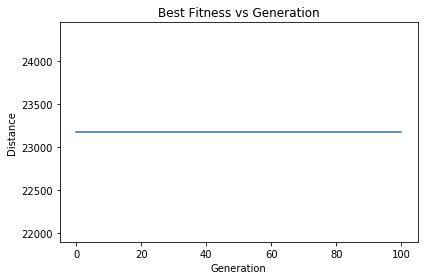

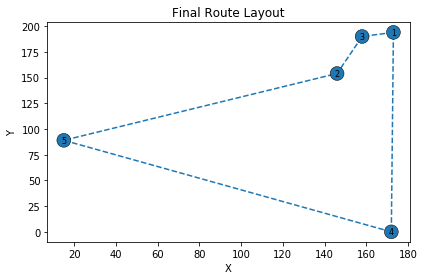

In [19]:
#Running the genetic algorithm
#Create list of cities

cityList = []

for i in range(0,5):
    cityList.append(City(name = i, x=int(random.random() * 200), y=int(random.random() * 200)))


best_route=geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=100)
x=[]
y=[]
for i in best_route:
  x.append(i.x)
  y.append(i.y)
x.append(best_route[0].x)
y.append(best_route[0].y)
plt.plot(x, y, '--o')
plt.xlabel('X')
plt.ylabel('Y')
ax=plt.gca()
plt.title('Final Route Layout')
bbox_props = dict(boxstyle="circle,pad=0.3", fc='C0', ec="black", lw=0.5)
for i in range(1,len(cityList)+1):
  ax.text(cityList[i-1].x, cityList[i-1].y, str(i), ha="center", va="center",
            size=8,
            bbox=bbox_props)
plt.tight_layout()
plt.show()